##Install Requirements - NLTK

In [126]:
pip -q install nltk

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import and observe dataset
<p>We all love watching movies! There are some movies we like, some we don't. Most people have a preference for movies of a similar genre. Some of us love watching action movies, while some of us like watching horror. Some of us like watching movies that have ninjas in them, while some of us like watching superheroes.</p>
<p>Movies within a genre often share common base parameters. Consider the following two movies:</p>
<p>Both movies, <em>2001: A Space Odyssey</em> and <em>Close Encounters of the Third Kind</em>, are movies based on aliens coming to Earth. I've seen both, and they indeed share many similarities. The conclusion is that both of these fall into the same genre of movies based on intuition, but that's no fun in a data science context. In this notebook, the similarity of movies will be quantified based on their plot summaries available on IMDb and Wikipedia, then separated into groups, also known as clusters. A dendrogram will be created to represent how closely the movies are related to each other.</p>


In [128]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage,dendrogram

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [129]:
# Set seed for reproducibility
np.random.seed(5)

In [130]:
# Read in IMDb and Wikipedia movie data (both in same file)
movies_df = pd.read_csv('/content/drive/MyDrive/movies.csv')

print("Number of movies loaded: %s " % (len(movies_df)))

Number of movies loaded: 100 


## 2. Combine Wikipedia and IMDb plot summaries
<p>The dataset  imported currently contains two columns titled <code>wiki_plot</code> and <code>imdb_plot</code>. They are the plot found for the movies on Wikipedia and IMDb, respectively. The text in the two columns is similar, however, they are often written in different tones and thus provide context on a movie in a different manner of linguistic expression. Further, sometimes the text in one column may mention a feature of the plot that is not present in the other column.</p>

In [131]:
# Combine wiki_plot and imdb_plot into a single column
movies_df['plot'] = movies_df['wiki_plot'].astype(str) + "\n" + \
                 movies_df['imdb_plot'].astype(str)

# Inspect the new DataFrame
movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


## 3. Tokenization and Stemming
<p>The plot column is tokenized(articles broken down into individual sentences or words, as needed). Besides the tokenization method provided by NLTK,a filtration is doneto remove tokens which are entirely numeric values or punctuation.</p>
<p>Stemming is also applied to the process to bring down a word from its different forms to the root word. This helps us establish meaning to different forms of the same words without having to deal with each form separately which will lead to a better establishment of meaning as some of the non-root forms may not be present in the NLTK training corpus.</p>
<p>There are different algorithms available for stemming such as the Porter Stemmer, Snowball Stemmer, etc.  Snowball Stemmer will be used.</p>

## 4. Create TfidfVectorizer
<p>Converting the  textual plot summaries to numbers for the computer to be able to extract meaning from them. One simple method of doing this would be to count all the occurrences of each word in the entire vocabulary and return the counts in a vector. Enter <code>CountVectorizer</code>.</p>
<p>Consider the word 'the'. It appears quite frequently in almost all movie plots and will have a high count in each case. But obviously, it isn't the theme of all the movies! Term Frequency-Inverse Document Frequency</a> (TF-IDF) is one method which overcomes the shortcomings of <code>CountVectorizer</code>. The Term Frequency of a word is the measure of how often it appears in a document, while the Inverse Document Frequency is the parameter which reduces the importance of a word if it frequently appears in several documents.</p>

<p> Also take filter out the stopwords'. These words  do not contribute considerably towards the meaning of the sentence and are generally grammatical filler words such as 'the' and 'her'.</p>


In [132]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

## 5. Fit transform TfidfVectorizer
<p>After the  TF-IDF Vectorizer is created, the text is  fitted to it and then transformed to produce the corresponding numeric form of the data which the computer will be able to understand and derive meaning from.</p>


In [121]:
# Fit and transform the tfidf_vectorizer with the "plot" of each movie
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["plot"]])

print(tfidf_matrix.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

(100, 564)


## 6. Import KMeans and create clusters
<p>In determining the relational proximity between movies through unsupervised learning, clustering techniques serve as a valuable tool. Within the dataset, the selection of a suitable criterion for clustering could be centered around movie genres.</p>

<p>The use of the K-means algorithm facilitates the implementation of clustering in Python. This process enables the categorisation and identification of movies into distinct clusters based on their inherent characteristics, specifically their genres, allowing for a comprehensive analysis of their interrelationships and groupings.</p>

> <p>Most movies are classified under **Cluster 2**</p>



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'Count')

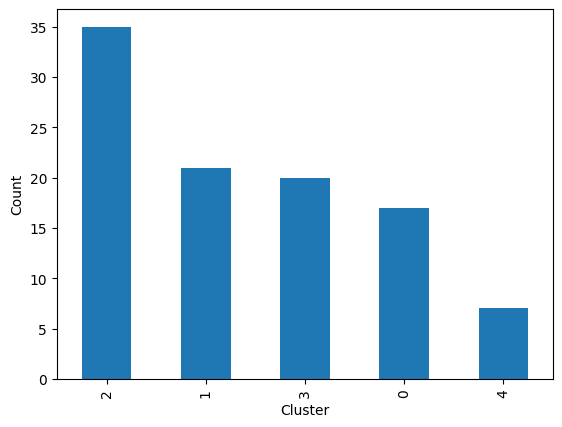

In [122]:
# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

#clusters
clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
movies_df['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')

In [123]:
#explore the clusters
movies_df[movies_df['cluster']== 2].head()

,rank,title,genre,wiki_plot,imdb_plot,plot,cluster
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit...",2
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight...",2
5,5,One Flew Over the Cuckoo's Nest,[u' Drama'],"In 1963 Oregon, Randle Patrick ""Mac"" McMurphy ...","In 1963 Oregon, Randle Patrick McMurphy (Nicho...","In 1963 Oregon, Randle Patrick ""Mac"" McMurphy ...",2
7,7,Citizen Kane,"[u' Drama', u' Mystery']",\n\n\n\nOrson Welles as Charles Foster Kane\n\...,"It's 1941, and newspaper tycoon Charles Foster...",\n\n\n\nOrson Welles as Charles Foster Kane\n\...,2
11,11,The Godfather: Part II,"[u' Crime', u' Drama']","\nIn 1901 Corleone, Sicily, nine-year-old Vito...",The Godfather Part II presents two parallel st...,"\nIn 1901 Corleone, Sicily, nine-year-old Vito...",2


## 7. Calculate similarity distance
<p>If the vectors are similar, the cosine of their angle would be 1 and hence, the distance between then would be 1 - 1 = 0.</p>

In [124]:
# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

## 8. Linkage and Dendrograms
<p>A tree-like diagram (called a dendrogram) of the movie titles is created to understand the level of similarity between them visually. Dendrograms help visualise the results of hierarchical clustering, which is an alternative to k-means clustering. Two pairs of movies at the same level of hierarchical clustering are expected to have similar strength of similarity between the corresponding pairs of movies.</p>

<p>A plot of a dendrogram of the movies whose similarity measure will be given by the similarity distance previously calculated. The lowest dendrogram linkage is between the movies, <em>It's a Wonderful Life</em> and <em>A Place in the Sun</em>. This indicates that the movies are very similar to each other in their plots.</p>

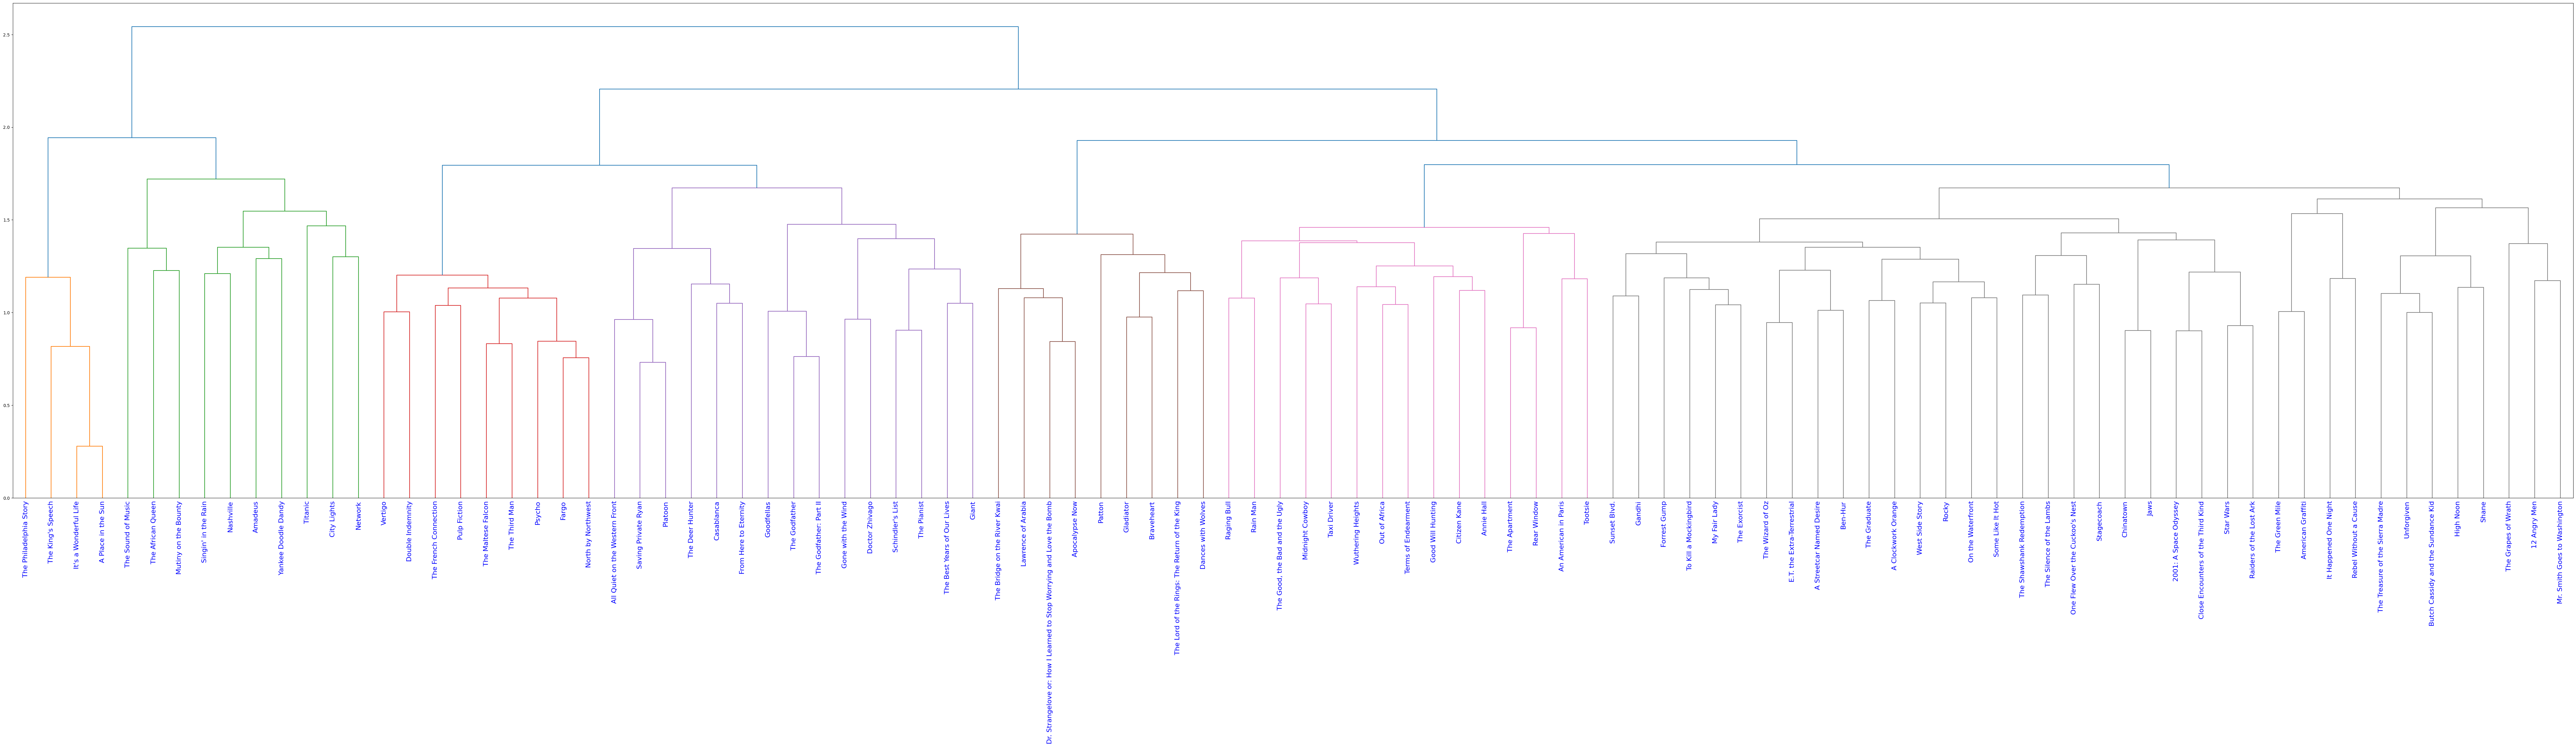

In [125]:
# Create mergings matrix
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies_df["title"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('blue') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

plt.show()